In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [2]:
# Matplotlib Settings
size=16
params = {
#     'font.sans-serif':'Arial',
    'legend.fontsize': 'large',
    'figure.figsize': (16,6),
    'figure.titlesize': size*1.3,
    'figure.titleweight': 'heavy',
    'axes.titlesize': size*2.,
    'axes.titleweight':'heavy',
    'axes.labelsize': size*1.5,
    'axes.labelweight': 'heavy',
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.titlepad': 10,
    'xtick.labelsize': size,
    'ytick.labelsize': size,
}
plt.rcParams.update(params)
plt.style.use('ggplot')

In [3]:
data_folder = Path('../data/')
feat_path = data_folder / 'features.csv'
test_path = data_folder / 'test.csv'
lab_path = data_folder / 'labels.csv'

In [4]:
df_feat = pd.read_csv(feat_path)
df_test = pd.read_csv(test_path)
df_lab = pd.read_csv(lab_path)

df = df_feat.merge(df_lab, on='trackID')

print(df_feat.shape, df_test.shape, df_lab.shape)

del df_feat, df_lab

(8128, 157) (428, 157) (8128, 2)


In [5]:
# Split the analysis into vector columns and non-vector columns
sel = df.columns.str.startswith('vect')
vec_cols = df.columns[sel]
non_vec_cols = df.columns[~sel]

# 1. Overview

#### Observations
- Small number of NA fields in some columns in train set (both vector & non vector fields)
- No NA fields in test set
- Dropping all NA fields in train set leads to ~5% loss of data
- Jazz & Blue and Dance & Electronica are the minority class (though not severely imbalanced)

#### Insights/ Decisions
- Drop all NA fields - since we still keep majority of the data
- This assumes that complete features can be extracted from new data

In [6]:
print('TRAIN SET (NON-VEC)', df[non_vec_cols].isna().sum(), '\n', sep='\n')
print('TEST SET (NON-VEC)', df_test[non_vec_cols[:-1]].isna().sum(), '\n', sep='\n')

print('TRAIN SET (VEC)', (df[vec_cols].isna().sum() == 0).value_counts(), '\n', sep='\n')
print('TEST SET (VEC)', (df_test[vec_cols].isna().sum() == 0).value_counts(), '\n', sep='\n')

TRAIN SET (NON-VEC)
trackID            0
title              7
tags              12
loudness          10
tempo             11
time_signature     9
key               15
mode               9
duration           9
genre              0
dtype: int64


TEST SET (NON-VEC)
trackID           0
title             0
tags              0
loudness          0
tempo             0
time_signature    0
key               0
mode              0
duration          0
dtype: int64


TRAIN SET (VEC)
False    107
True      41
dtype: int64


TEST SET (VEC)
True    148
dtype: int64




In [7]:
print(f'Percentage Train Data Left (After Dropping NA): {len(df.dropna()) / len(df):.2%}')

Percentage Train Data Left (After Dropping NA): 95.03%


In [8]:
# Drop the na columns
df.dropna(inplace=True)
assert df.isna().sum().sum() == 0, 'Rows with NA columns still exist, check `dropna`'

<AxesSubplot:title={'center':'Genre Total Counts'}>

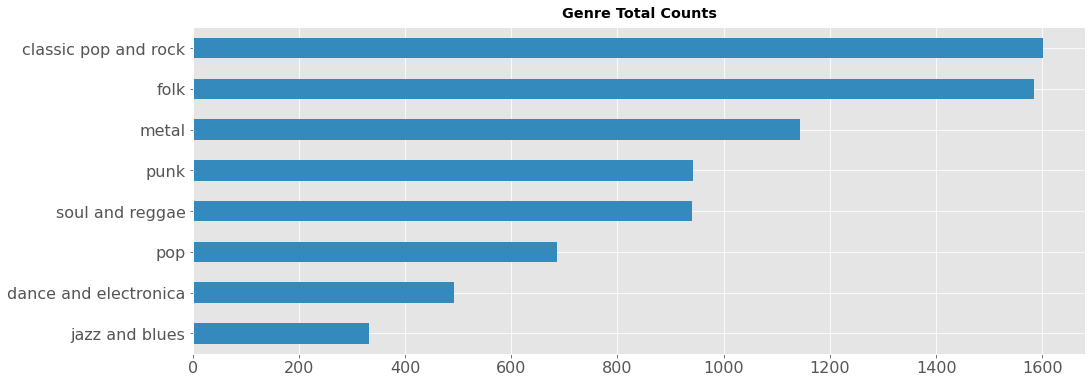

In [9]:
(
    df['genre']
    .value_counts()
    .sort_values()
    .plot(kind='barh', color='C1', title='Genre Total Counts')
)

# 2. Loudness, Tempo & Time Signature

#### Observations
- Punk & Metal seems to louder (higher Db) in general
- Punk seems to be of higher tempo in general (distribution is centered around 150 BPM, while most other genres' center around 100 BPM)
- Jazz & Blues seems to be of higher time signature (BBP) than the other genres

#### Insights/ Decisions
- Might be a good idea to engineer a new categorical feature out of time signature

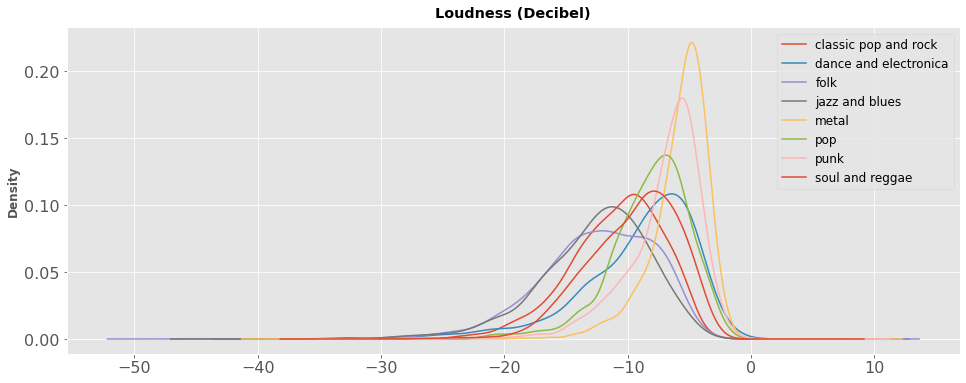

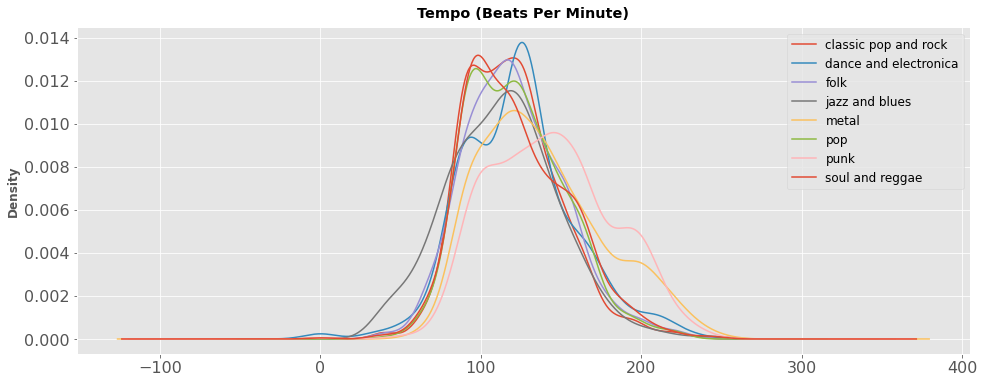

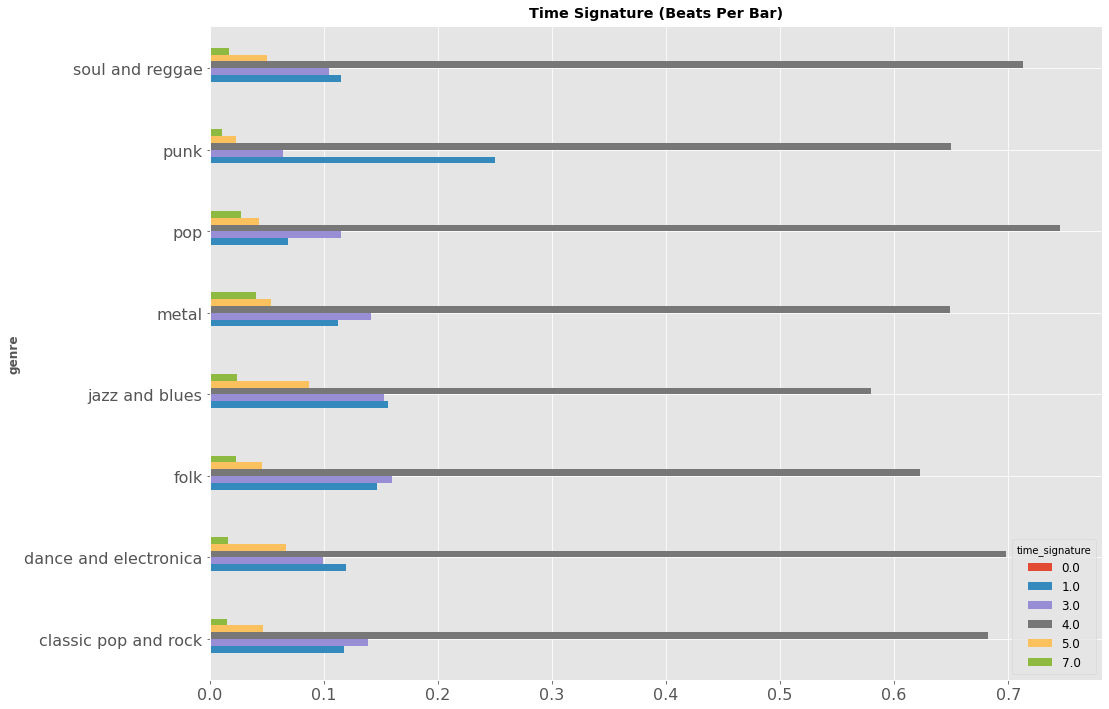

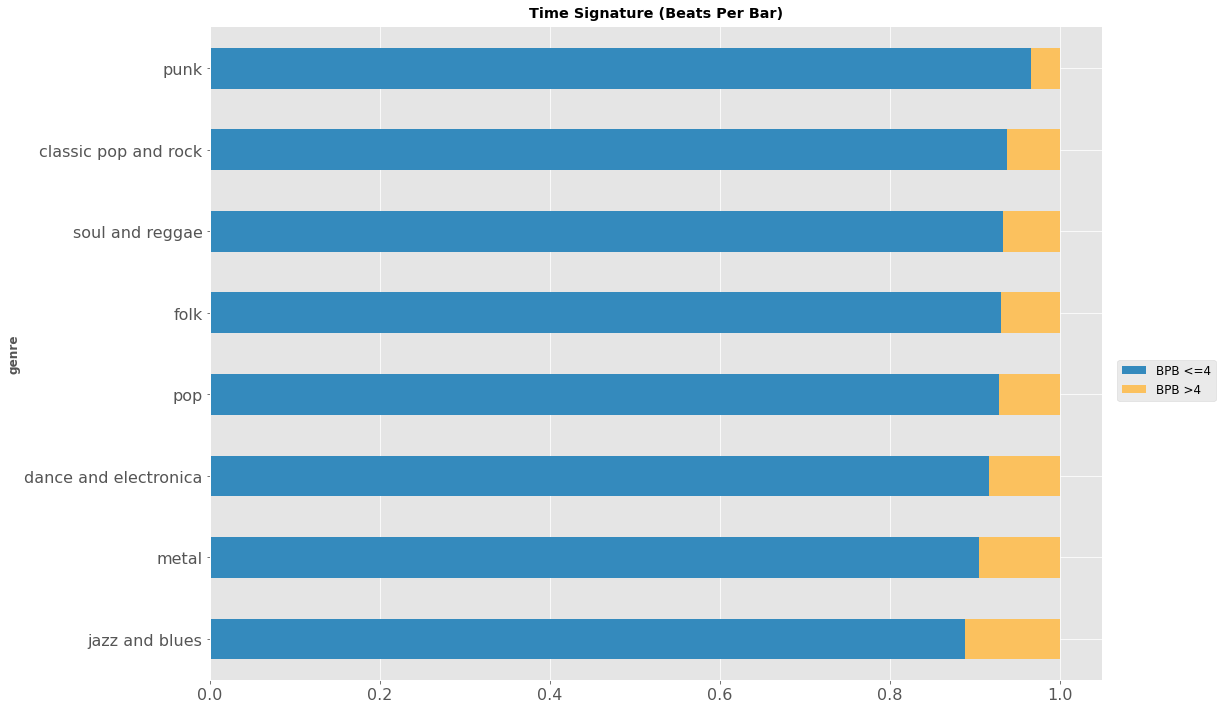

In [10]:
# Plot Loudness and Tempo KDE
plot_dict = {
    'loudness':'Loudness (Decibel)',
    'tempo':'Tempo (Beats Per Minute)',
}

for col, title in plot_dict.items():
    (
        df
        .groupby('genre')
        [col]
        .plot(kind='kde', legend=True, title=title) 
    )
    plt.show()

# Plot Time Signature Barchart (BPB as groups)
(
    df[['genre','time_signature']]
    .groupby('genre')
    ['time_signature']
    .value_counts(normalize=True)
    .sort_index()
    .unstack()
    .fillna(0)
    .plot(kind='barh', figsize=(16,12), title = 'Time Signature (Beats Per Bar)')
)
plt.show()

# Plot Time Signature Barchat (2 groups - Less than/ Equal to 4, More than 4)
(
    df[['genre','time_signature']]
    .assign(time_signature=lambda x : x.time_signature <= 4)
    .replace({True: 'BPB <=4', False: 'BPB >4'})
    .groupby('genre')
    ['time_signature']
    .value_counts(normalize=True)
    .sort_index()
    .unstack()
    .fillna(0)
    .sort_values('BPB <=4')
    .plot(
        kind='barh',
        figsize=(16,12),
        title = 'Time Signature (Beats Per Bar)',
        stacked=True,
        color=['C1','C4']
    )
    .legend(bbox_to_anchor=[1.01,0.5])
)
plt.show()

# 3. Key and Mode

#### Background Info
There are 12 Minor & Major keys in music, each corresponding a particular ["feel"](https://www.biteyourownelbow.com/keychar.htm), and thus these 2 columns `key` and `mode` should be read together.

The easiest way to make them categorical is by casting them to string and concatenate them. To fully uncover the trends, we will plot grouped bar charts for Key, Mode and Key/Mode.

#### Observations
##### 1. Key/Mode
- 00|01, 02|01, 07|01 seems to be the most popular Key/Mode, regardless of genre (in other words, it is much more challenging to get the right genre when the song is of one of these keys)
- 00|01 is a popular Key/Mode for classic pop & rock, dance & electronica, jazz & blues, soul & reggae
- 02|01 is a popular Key/Mode for punk
- 08|00 seems to be an unlikely choice for punk

##### 2. Key, Mode (Separately)
- Most genre has Mode = 01, those are probaly the Major keys



#### Insights / Decisions
- Overall the key seems to be noisy feature that might not be useful in genre classification
- Throw away Key and Mode, keep Key/Mode

In [11]:
# Process Key and Mode to be double digits, with preceding 0 where needed
df[['key','mode']] = (
    df[['key','mode']]
    .applymap(lambda x : f'{int(x):02d}')
)

# Combine both key and mode
df['key_mode'] = (
    df[['key','mode']]
    .apply(lambda x : '|'.join(x), axis=1)
)

[]

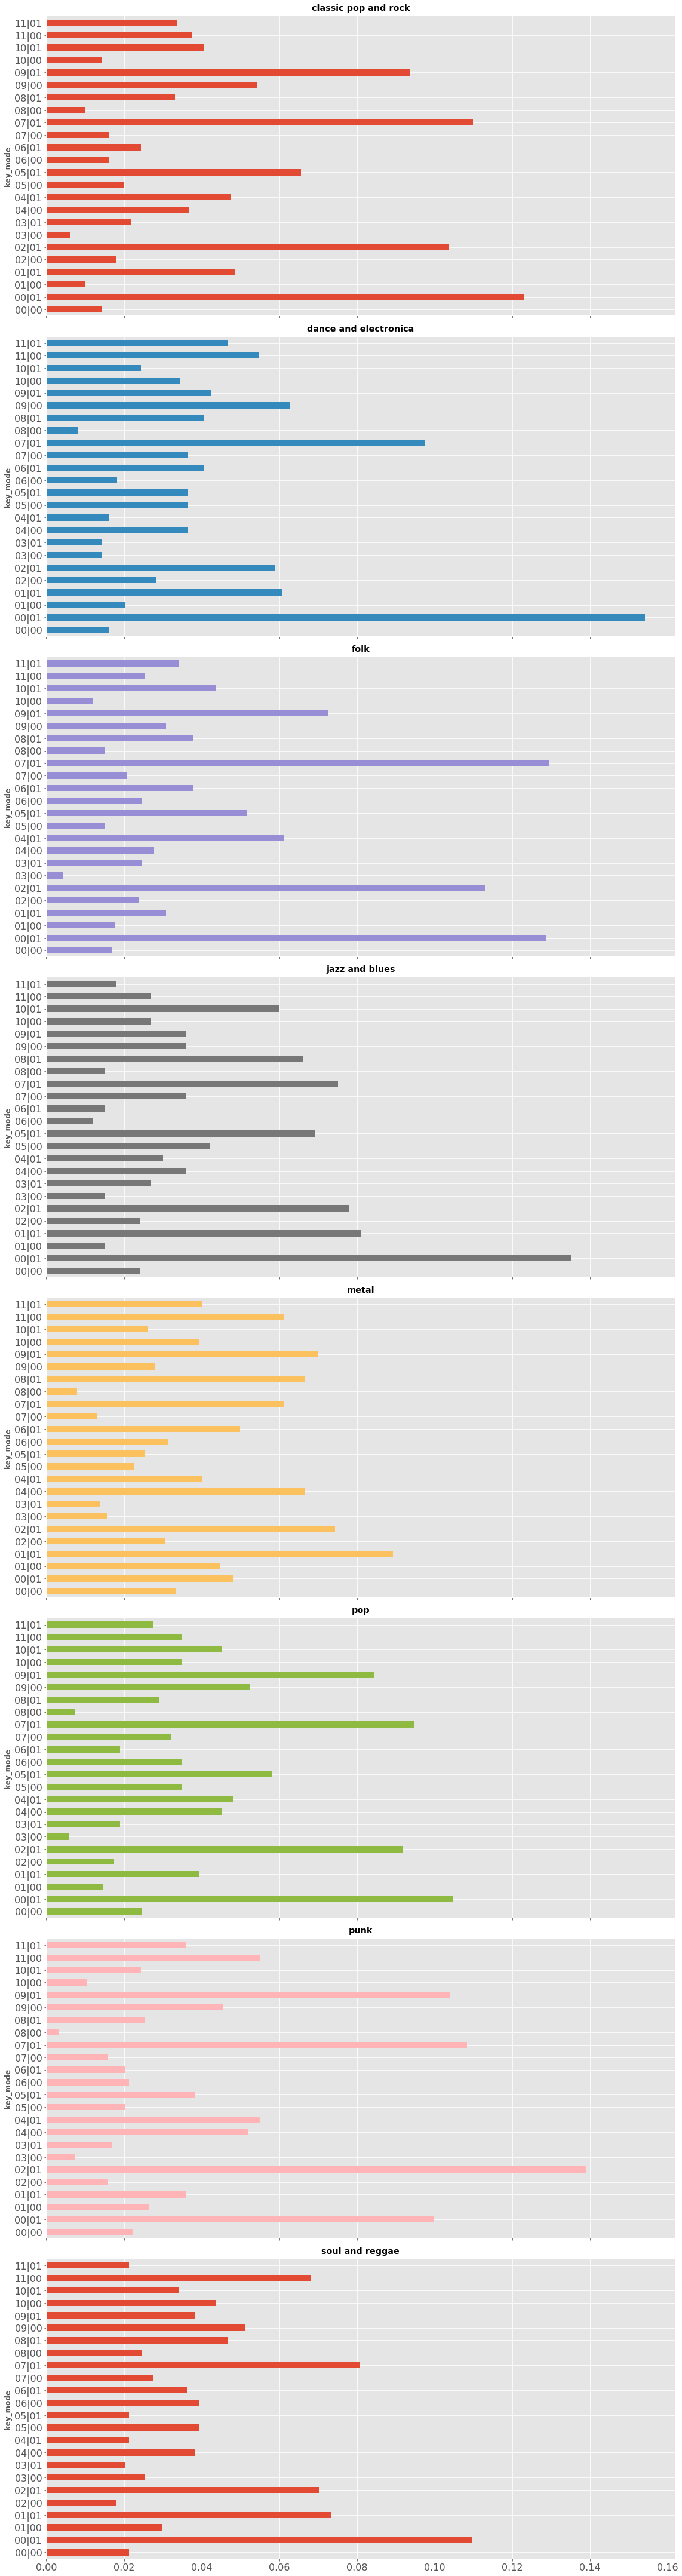

In [12]:
# Plot the proportion of key_mode within each genre

(
    df
    .groupby('genre')
    ['key_mode']
    .value_counts(normalize=True)
    .sort_index()
    .unstack(-1)
    .T
    .fillna(0)
    .plot(kind='barh', subplots=True, figsize=(16,60), legend=False)
)

plt.tight_layout()
plt.plot()

[]

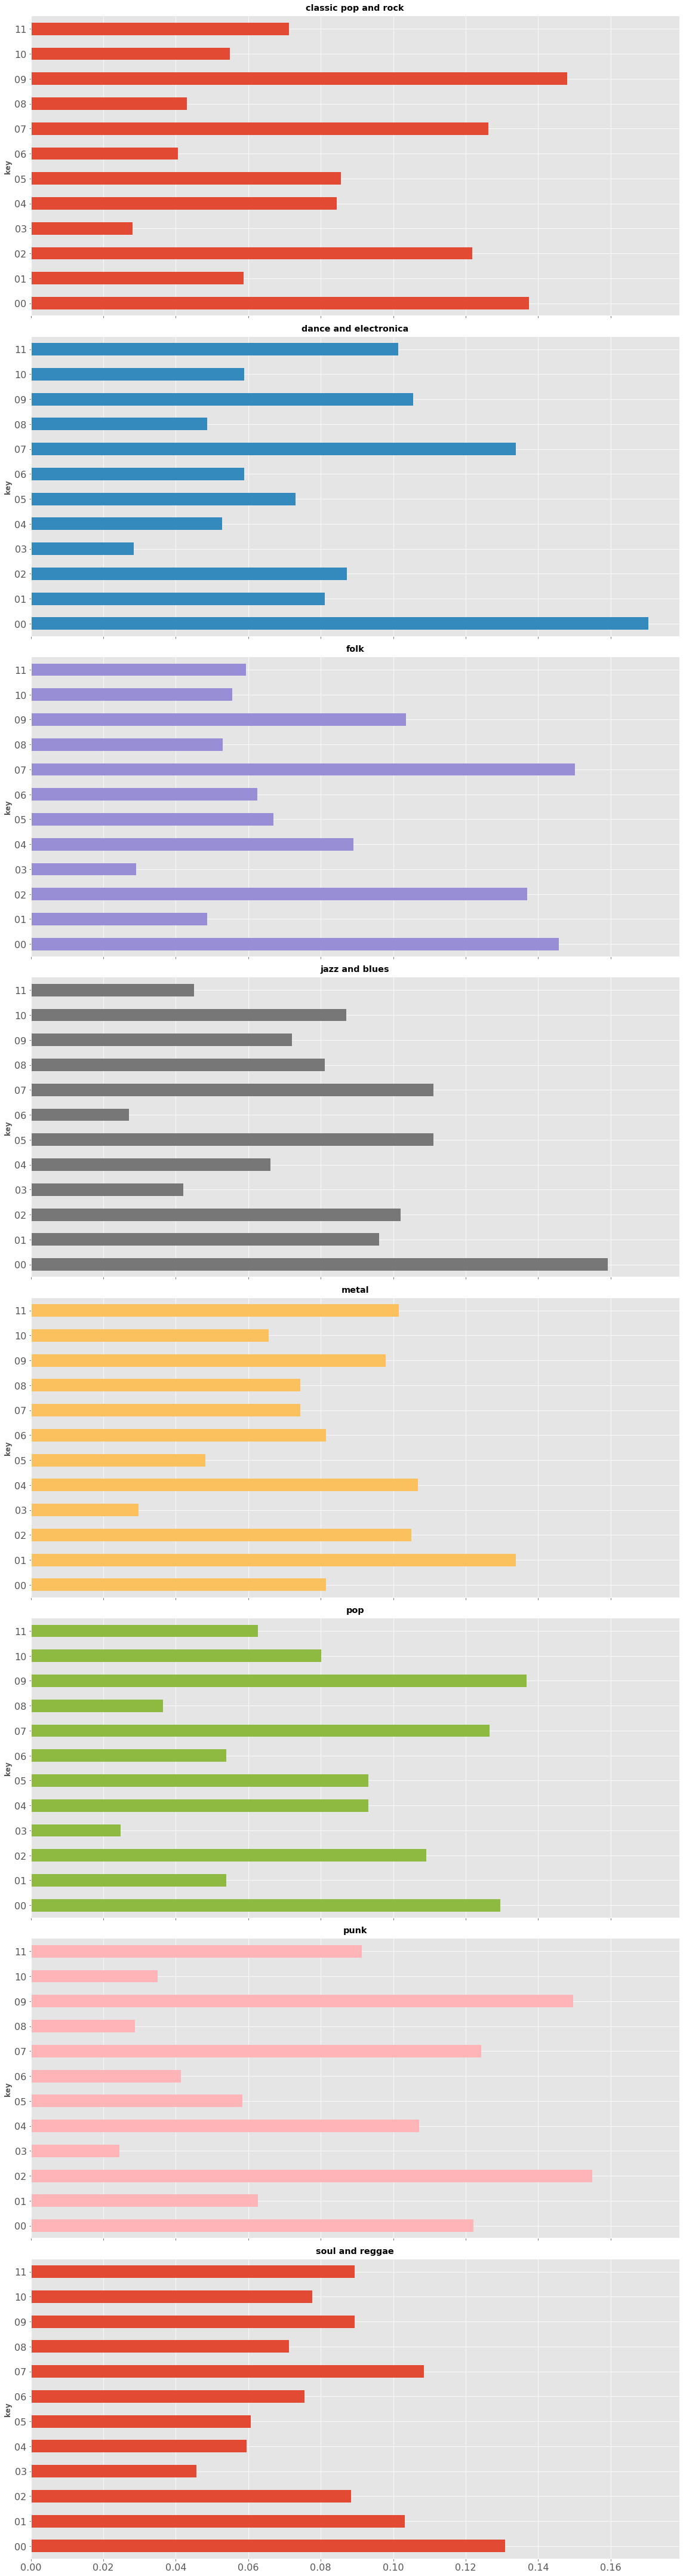

In [13]:
# Plot the proportion of key within each genre

(
    df
    .groupby('genre')
    ['key']
    .value_counts(normalize=True)
    .sort_index()
    .unstack(-1)
    .T
    .fillna(0)
    .plot(kind='barh', subplots=True, figsize=(16,60), legend=False)
)

plt.tight_layout()
plt.plot()

[]

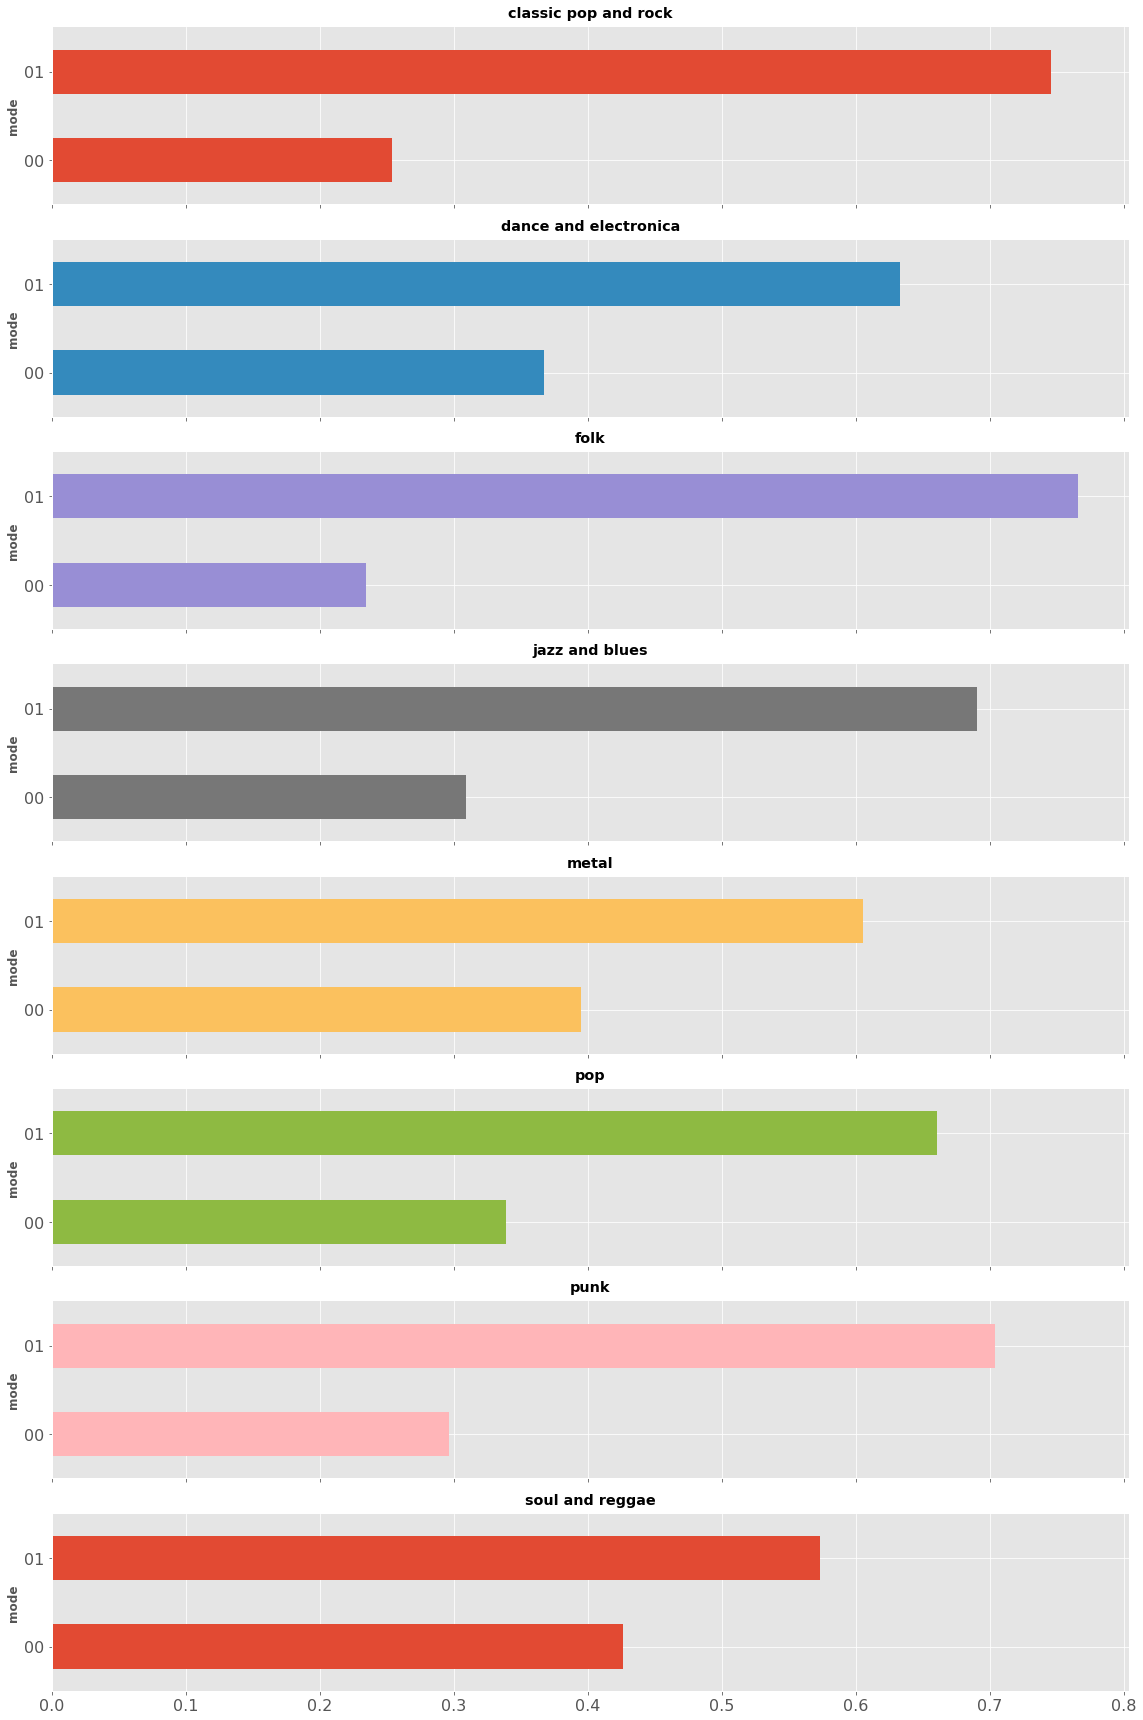

In [14]:
# Plot the proportion of mode within each genre

(
    df
    .groupby('genre')
    ['mode']
    .value_counts(normalize=True)
    .sort_index()
    .unstack(-1)
    .T
    .fillna(0)
    .plot(kind='barh', subplots=True, figsize=(16,24), legend=False)
)

plt.tight_layout()
plt.plot()

# 4. Song Duration

#### Observations
- Lots of outliers across genres
- Generally metal seems to be of longer duration
- Pop seems to have a narrower distribution, all centered close to ~220 seconds

#### Insights/ Decisions
- By itself, song duration is not a good feature to predict genre

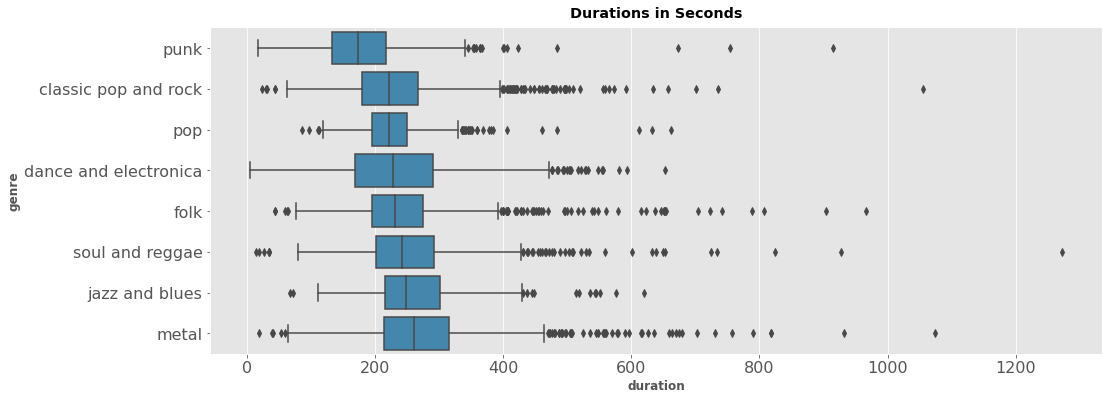

In [15]:
# Get the median to sort boxplot
sort_order = (
    df
    .groupby('genre')
    ['duration']
    .median()
    .sort_values()
    .index
)

fig, ax = plt.subplots(1,1)

sns.boxplot(
    y=df['genre'],
    x=df['duration'],
    order=sort_order,
    orient='h',
    color='C1',
    ax=ax
)

ax.set_title('Durations in Seconds')
plt.show()

# 5. Song Title & Tags

#### Observations

##### 1. General
- Accented characters are found in ~1% of the song titles and 7% of the song tags. These songs are most probably in Spanish or other non-English languages

##### 2. Song Title
- A significant portion of the song titles has additional (not so useful) meta in bracket content (e.g. Album Version, LP Version, Remastered)
- From the word cloud, the genre with distinct keywords are Metal (e.g. god, black, dead, evil), Punk (world, profanity) and Pop (Spanish vocabs like amor); and `love` seems to associate with almost all genres (except Metal)
- From the pretrained transformer embeddings UMAP, the embeddings of most genre spreads about quite evenly, except Pop, which has a cluster formed on the right hand bubble. This supports the findings from word cloud too (where Pop is dominated by Spanish vocab)

##### 3. Tags
- Lots of stopwords in tags (i, you, the)
- From the word cloud, the genres are almost indistinguishable (except for Metal and Pop)
- In terms of unique tag counts, it is similar across genre too (i.e. probably not a useful feature)
- From the tfidf embeddings UMAP, we see the clusters seems to be better separated than the song title embeddings:
    1. Metal seems to be more prominent in the right-half of the bottom left cluster, while most other genres occupy the left-half more
    2. Punk and Pop seems to have more presence in the top right cluster
    3. Punk is found more often than the other genres in the small middle right cluster

#### Insights/Decisions
- Overall, the TFIDF embeddings from the processed tags seems more informative than the song title embeddings
- For now, keep both for modelling; if the performance between using song title embeddings and not is comparable, drop the song title embeddings (expensive to compute since it is a pretrained transformer)
- Meta data on number of unique tag is not useful, so not going to include the feature

In [16]:
import re

from collections import Counter
from nltk import corpus
from unidecode import unidecode
from wordcloud import WordCloud

In [17]:
def simple_preprocessing(txt, stopwords=None):
    
    # Lowercasing - works on accented characters too
    txt = txt.lower()
    
    # Remove bracket & content
    txt = re.sub('\(.*?\)', ' ', txt)
    
    # Convert accented characters to their closest ASCII character
    # e.g. Gönül -> Gonul
    txt = unidecode(txt)
    
    # Remove anything that isn't a-z
    txt = re.sub('[^a-z ]', ' ', txt)
    
    # Standardize spacing
    txt = re.sub('\s+',' ', txt).strip()
    
    if stopwords is not None:
        # Remove stopwords
        sw_pattern = '\\b(' + '|'.join(stopwords) + ')\\b'
        txt = re.sub(sw_pattern, ' ', txt)

        # Standardize spacing again
        txt = re.sub('\s+',' ', txt).strip()
    
    return txt

In [18]:
# Unicode for accented chars (Ref - https://stackoverflow.com/a/62251583/10841164)

accented_chars = '[\u00C0-\u017F]'

sel = df['tags'].str.contains(accented_chars)
print(f'Around {sel.sum() / len(df):.2%} of the songs contain accented tags.')

sel = df['title'].str.contains(accented_chars)
print(f'Around {sel.sum() / len(df):.2%} of the songs contain accented titles.')

Around 7.19% of the songs contain accented tags.
Around 1.23% of the songs contain accented titles.


In [19]:
# Get & process stopwords
stopwords = list(map(simple_preprocessing, corpus.stopwords.words('english')))

# Process title and tags
df['processed_title'] = df['title'].apply(lambda x : simple_preprocessing(x, stopwords))
df['processed_tags'] = df['tags'].apply(lambda x : simple_preprocessing(x, stopwords))

# Generate stats for unprocessed tags
df['tag_count'] = df['tags'].str.split(',\s*').apply(len)

# Generate stats for processed tags
df['processed_tag_count'] = df['processed_tags'].str.split('\s+').apply(len)

In [20]:
def plot_word_cloud_by_genre(df, text_col, title):
    
    # Visualize Word Cloud of Song Title
    fig, ax = plt.subplots(2, 4, figsize=(16,12))
    ax = ax.ravel()

    for i, genre in enumerate(df['genre'].unique()):

        # Generate genre's freq dist
        freq_dist = Counter(
            df
            .query('genre == @genre')
            [text_col]
            .apply(lambda x : x.split())
            .explode()
            .dropna()
            .tolist()
        )

        wordcloud = (
            WordCloud(
                background_color='White', width=600, height=800, random_state=2021
            )
            .generate_from_frequencies(freq_dist)
        )

        ax[i].imshow(wordcloud, interpolation='bilinear')
        ax[i].axis('off')
        ax[i].set_title(genre.title())
    
    fig.suptitle(title)

    return fig

CPU times: user 5.76 s, sys: 151 ms, total: 5.91 s
Wall time: 5.89 s


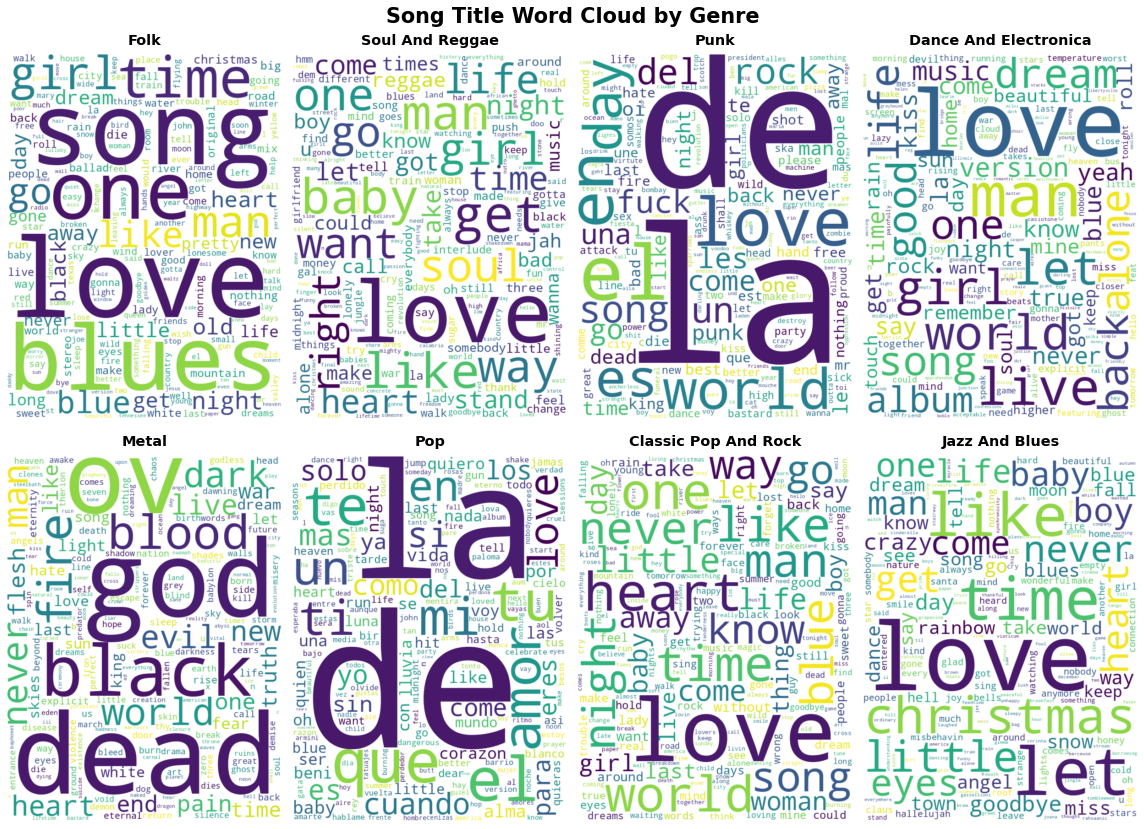

In [21]:
%%time
fig = plot_word_cloud_by_genre(df, 'processed_title', 'Song Title Word Cloud by Genre')
fig.tight_layout()

CPU times: user 6.2 s, sys: 213 ms, total: 6.41 s
Wall time: 6.39 s


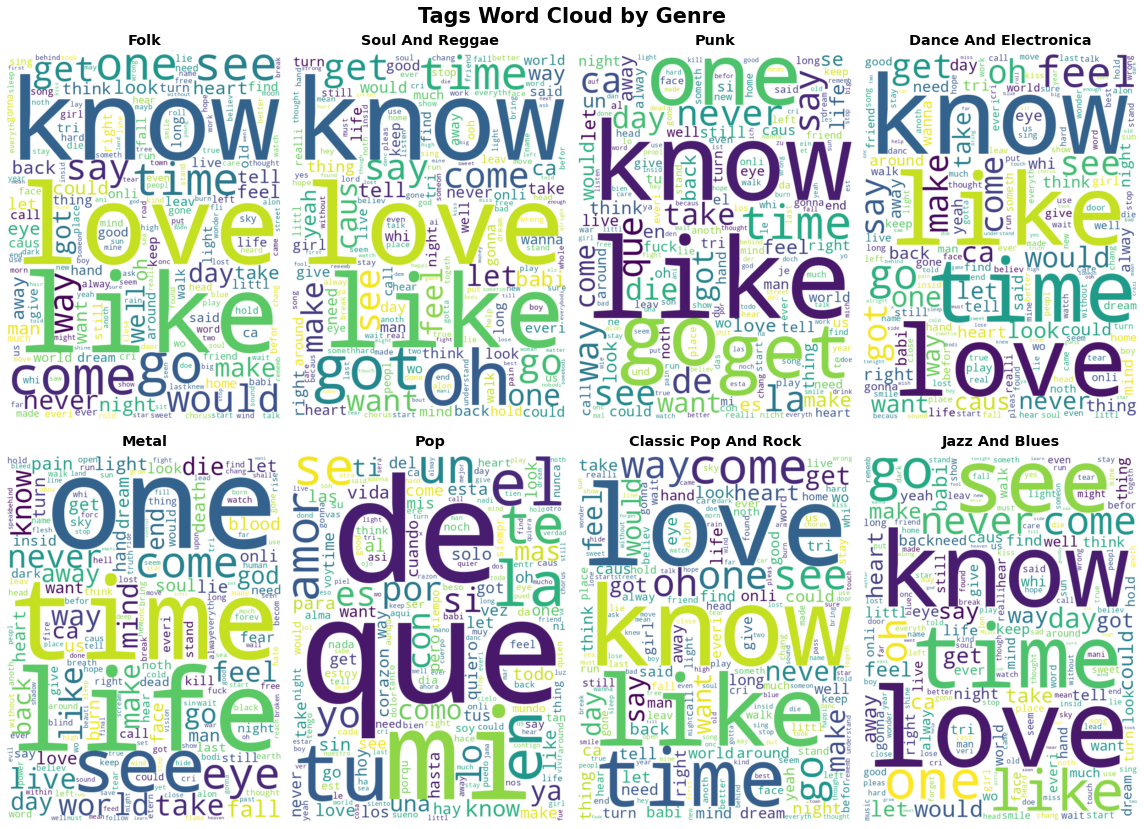

In [22]:
%%time
fig = plot_word_cloud_by_genre(df, 'processed_tags', 'Tags Word Cloud by Genre')
fig.tight_layout()

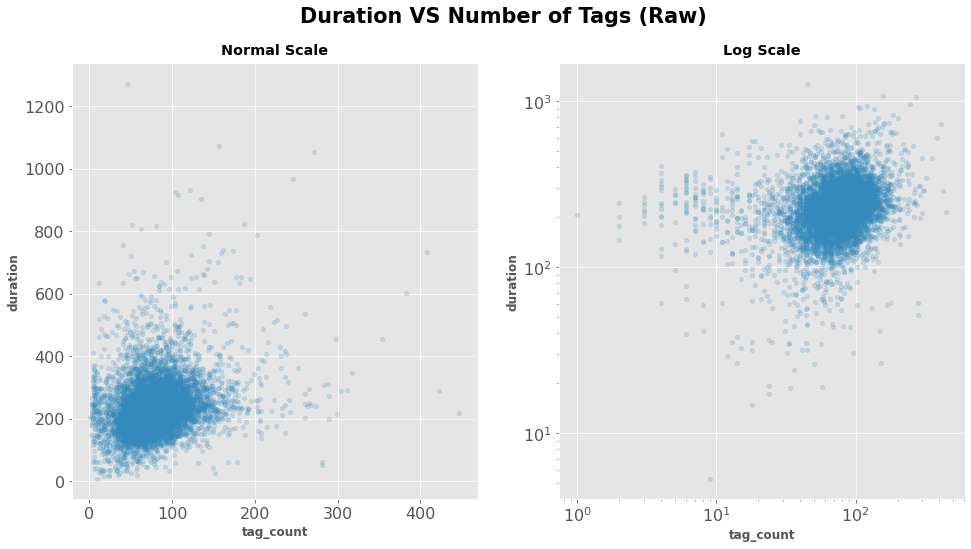

In [23]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

ax[1].set_yscale('log')
ax[1].set_xscale('log')

plot_params = dict(
    kind='scatter',
    x='tag_count',
    y='duration',
    alpha=0.2,
)

(
    df
    .plot(
        ax=ax[0],
        title='Normal Scale',
        **plot_params
    )
)

(
    df
    .plot(
        ax=ax[1],
        title='Log Scale',
        **plot_params
    )
)

fig.suptitle('Duration VS Number of Tags (Raw)')
plt.show()

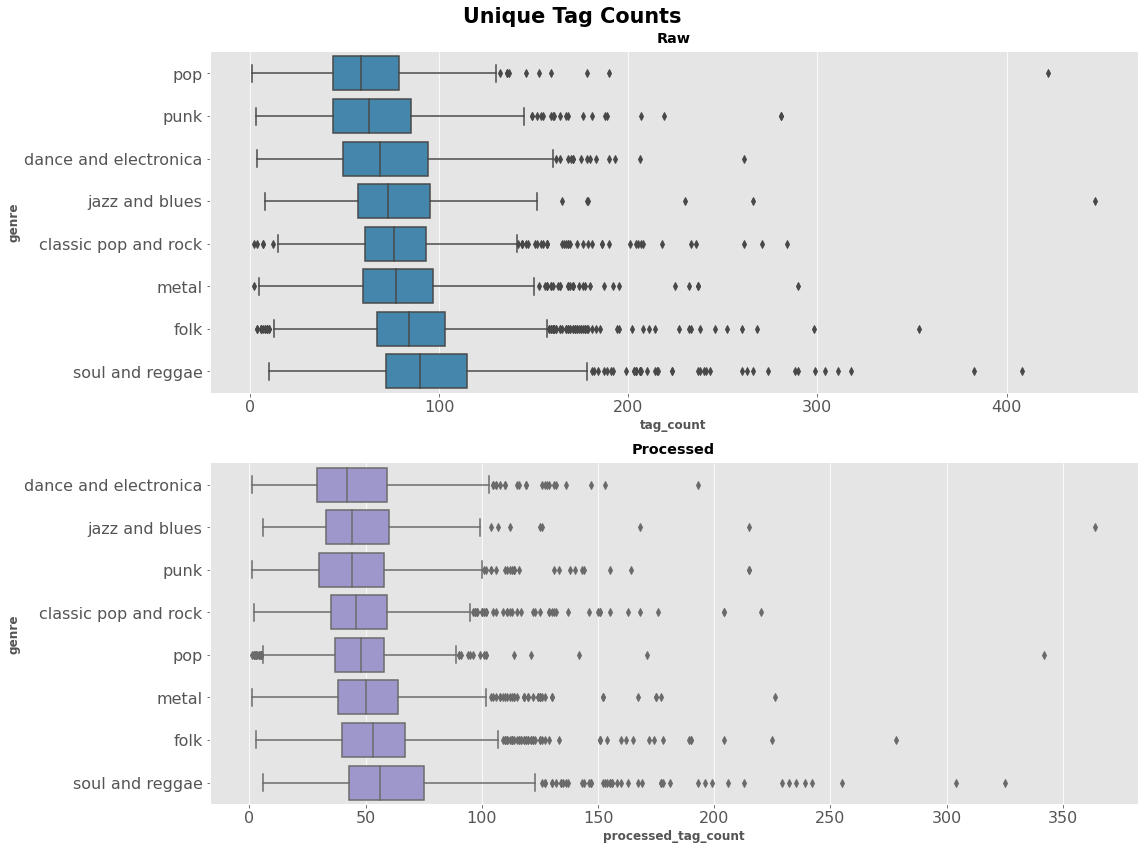

In [24]:
fig, ax = plt.subplots(2,1, figsize=(16,12))


plot_params = {
    'tag_count':'Raw',
    'processed_tag_count':'Processed'}

for i, (col, desc) in enumerate(plot_params.items()):

    # Get the median to sort boxplot
    sort_order = (
        df
        .groupby('genre')
        [col]
        .median()
        .sort_values()
        .index
    )


    sns.boxplot(
        y=df['genre'],
        x=df[col],
        order=sort_order,
        orient='h',
        color=f'C{i+1}',
        ax=ax[i]
    )

    ax[i].set_title(desc.title())

fig.suptitle('Unique Tag Counts')
fig.tight_layout()

In [25]:
import numpy as np
import torch

from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModel
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from umap import UMAP

In [26]:
class SongTitleDataset(Dataset):

    def __init__(
            self,
            df: pd.DataFrame,
            pretrained_path: str,
            text_col: str = 'title',
            label_col: str = None,
            **tokenizer_args):

        assert text_col in df.columns, f'{text_col} is not a column in df'
        self.df = df.reset_index(drop=True)
        self.text_col = text_col
        self.label_col = label_col
        self.tokenizer = AutoTokenizer.from_pretrained(
            pretrained_path, **tokenizer_args)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        row = self.df.iloc[idx]
        data = self.tokenizer(
            row[self.text_col],
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        data = dict((k, v.squeeze()) for k, v in data.items())

        if self.label_col is not None:
            data['label'] = row[self.label_col]

        return data

In [27]:
def mean_pooling(out, att_mask):
    
    tok_embs = out[0]
    exp_mask = att_mask.unsqueeze(-1).expand(tok_embs.size()).float()
    sum_emb = torch.sum(tok_embs * exp_mask, 1)
    sum_mask = torch.clamp(exp_mask.sum(1), min=1e-9)
    
    return sum_emb / sum_mask

In [28]:
def plot_umap(emb, labels, label2id, title):
    
    fig, ax = plt.subplots(2,4,figsize=(16,12))
    ax = ax.ravel()

    for ax_title, ax_id in label2id.items():

        ax[ax_id].set_title(ax_title)
        ax[ax_id].axis('off')

        # Plot the ax's genre last so that it doesn't get blocked by others
        for genre, lab_id in label2id.items():

            if ax_id == lab_id:
                continue

            ax[ax_id].scatter(
                emb[labels == lab_id, 0],
                emb[labels == lab_id, 1],
                c='lightgray',
                alpha=0.5,
                s=15
            )

        ax[ax_id].scatter(
            emb[labels == ax_id, 0],
            emb[labels == ax_id, 1],
            c=f'C{ax_id}',
            s=15
        )

    fig.suptitle(title)
    fig.tight_layout()
    
    return fig

In [29]:
# For title embeddings, we remove brackets

df['title_wo_brackets'] = (
    df['title']
    .str.replace('\(.*?\)', ' ')
    .str.replace('\s+',' ')
    .str.strip()
)

/tmp/ipykernel_152676/1856951189.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['title']


In [30]:
# Load pretrained transformer
model_path = Path('../model/paraphrase_tinybert/')
# model_path = 'distilbert-base-cased'

device = 'cuda' if torch.cuda.is_available else 'cpu'
device

model = AutoModel.from_pretrained(model_path)
model = model.to(device)

In [31]:
# Generate embeddings for all data

batch_size = 512

title_data = SongTitleDataset(
    df[['title_wo_brackets']],
    pretrained_path=model_path,
    text_col='title_wo_brackets',
    model_max_length=48
)

title_dataloader = DataLoader(title_data, batch_size=batch_size, shuffle=False)

In [32]:
title_emb = np.zeros((len(title_data), 768), dtype=np.float32)

with torch.no_grad():

    for i, batch in enumerate(tqdm(title_dataloader, total=len(title_dataloader))):
        batch = dict((k, v.cuda()) for k, v in batch.items())
        out =  model(**batch)
        embs = mean_pooling(out, batch['attention_mask'])
        title_emb[i*batch_size: (i+1)*batch_size] = embs.cpu().detach()

100%|███████████████████████████████████████████| 16/16 [00:11<00:00,  1.45it/s]


In [33]:
label2id = dict((genre, i) for i, genre in enumerate(df['genre'].unique()))
id2label = dict((v, k) for k, v in label2id.items())
labels = df['genre'].map(label2id).values

In [34]:
%%time
umap_embedder = UMAP(
    n_neighbors=30,
    min_dist=0.5,
    metric='cosine',
    random_state=2021
)

umap_emb_title = umap_embedder.fit_transform(title_emb)

CPU times: user 24.6 s, sys: 1.41 s, total: 26 s
Wall time: 17.9 s


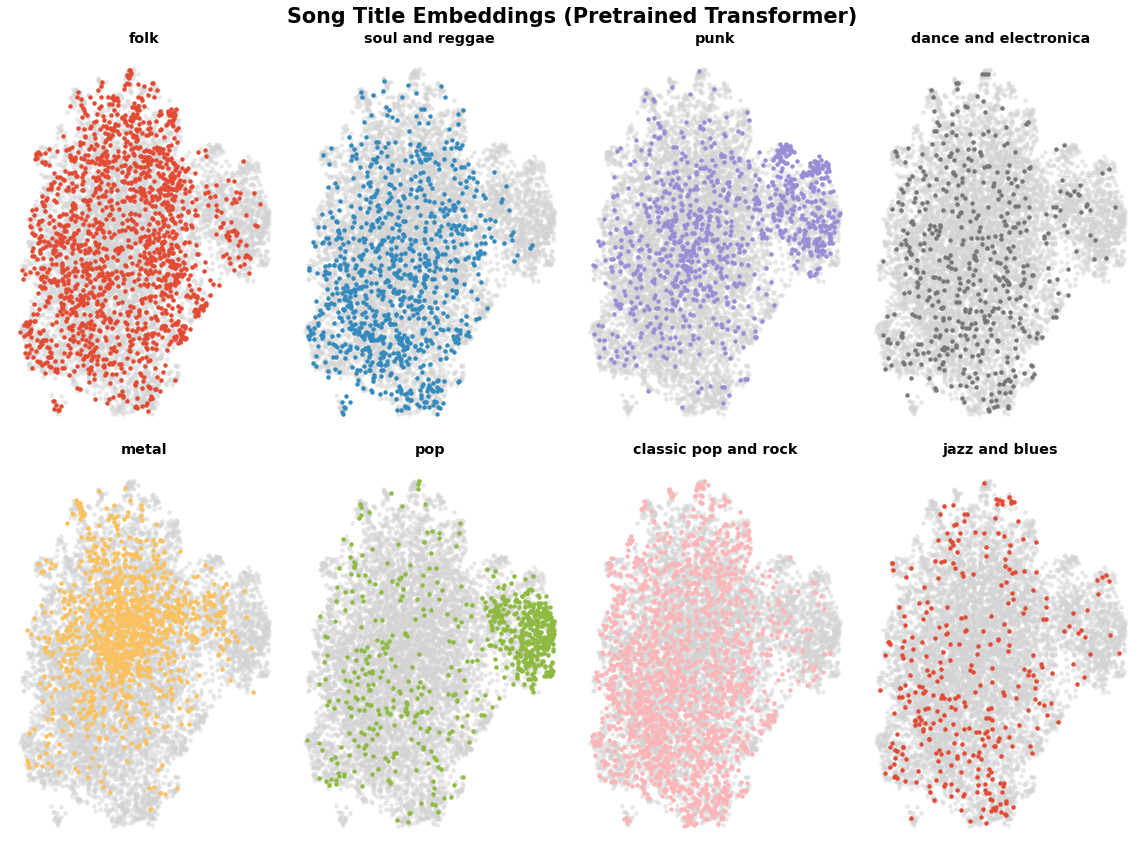

In [35]:
_ = plot_umap(umap_emb_title, labels, label2id, 'Song Title Embeddings (Pretrained Transformer)')

In [36]:
# Convert processed tagas to TFIDF
vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=25_000
)

tfidf_emb = vectorizer.fit_transform(df['processed_tags'])

In [37]:
%%time
umap_embedder = UMAP(
    n_neighbors=30,
    min_dist=0.5,
    metric='cosine',
    random_state=2021
)

umap_emb_tfidf = umap_embedder.fit_transform(tfidf_emb)

/home/chewzy/Personal/dbs_data_science/.venv/lib/python3.8/site-packages/umap/umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 75 edges.
It has only fully disconnected 1 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


CPU times: user 2min 19s, sys: 2min 19s, total: 4min 38s
Wall time: 44.8 s


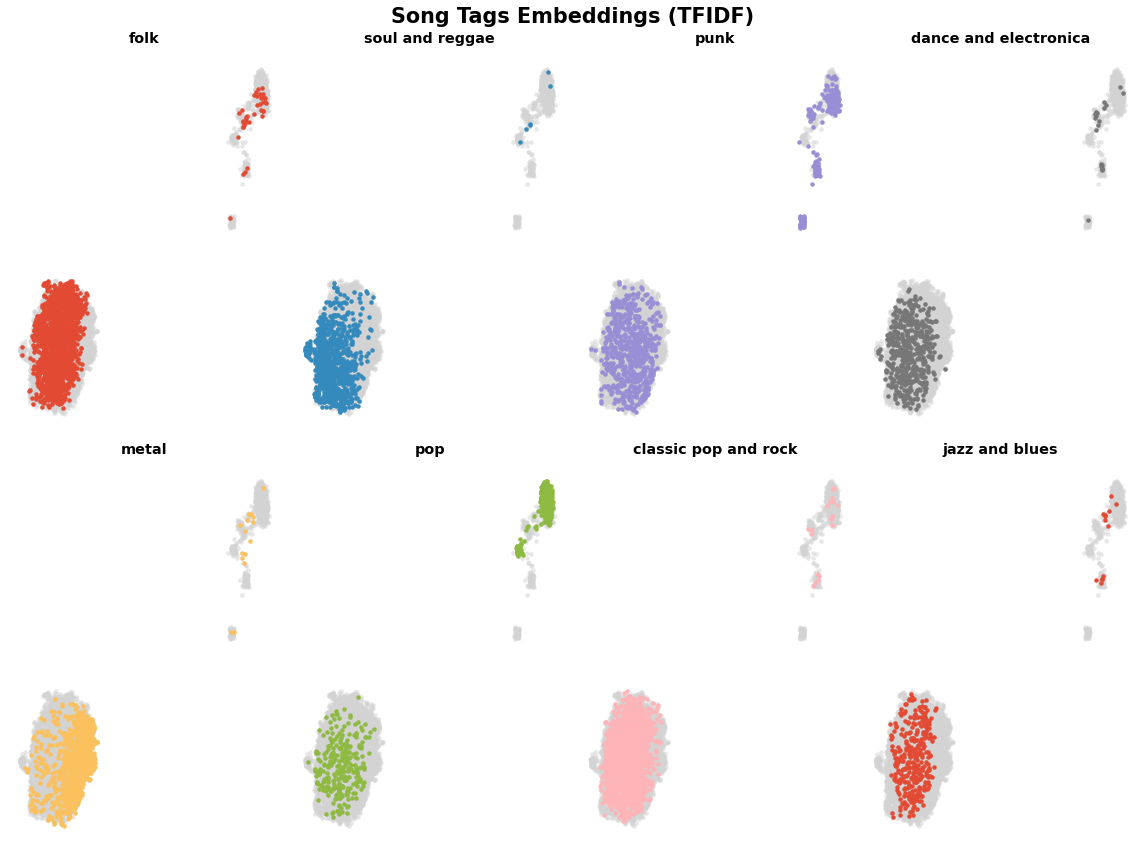

In [38]:
_ = plot_umap(umap_emb_tfidf, labels, label2id, 'Song Tags Embeddings (TFIDF)')

# 6. Vector Fields

#### Observations
- Lots of correlated features (e.g. vect_42 to vect_52)

#### Insights/Decisions
- Drop those features that have correlation coefficient of more than 0.7 (or find a better threshold by doing cross validation)

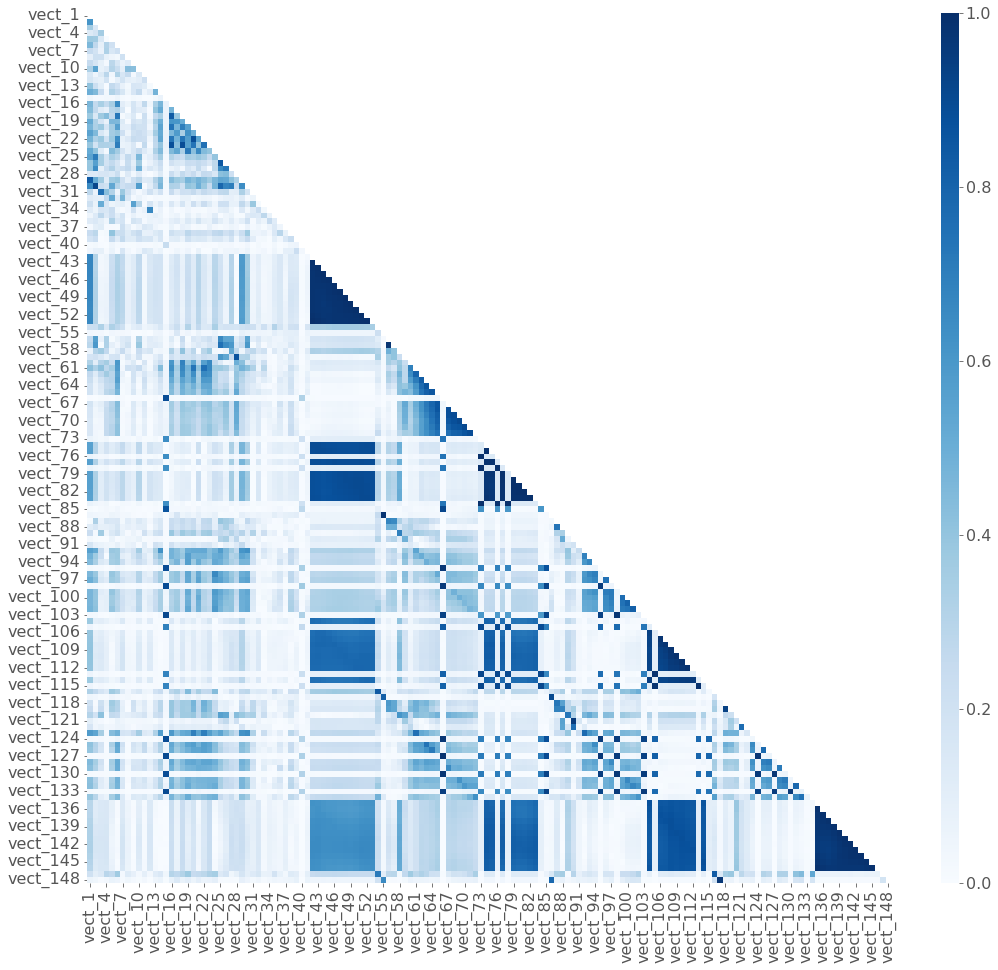

In [39]:
corr_mat = df[vec_cols].corr().abs()
mask = np.zeros_like(corr_mat, dtype=bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(1,1, figsize=(18, 16))
sns.heatmap(
    corr_mat, cmap='Blues', mask=mask, vmin=0, vmax=1, ax=ax, cbar_kws={'aspect':50}
)
ax.set_facecolor("white")
plt.show()

In [40]:
# Select non-correlated features

thres = 0.7

# Convert to array, mask diagonal, since it is always 1
corr_mat_arr = corr_mat.values
np.fill_diagonal(corr_mat_arr, 0)

cols_remaining = list(np.arange(len(corr_mat_arr)))

for i in range(len(corr_mat_arr)):
    
    if i not in cols_remaining:
        continue
        
    idx_to_removed = np.where(corr_mat_arr[i] > thres)[0]
    
    for idx in idx_to_removed:
        try:
            _ = cols_remaining.remove(idx)
        except ValueError:
            pass

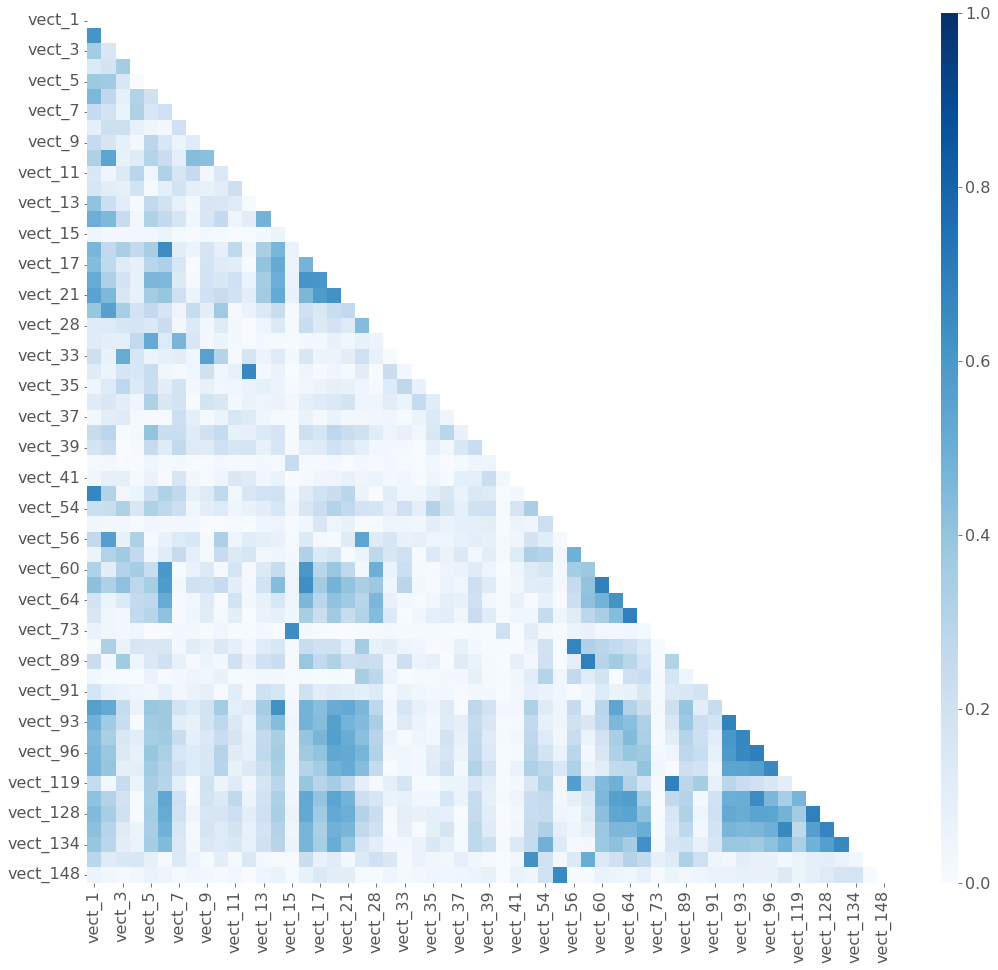

In [41]:
corr_mat_processed = df[vec_cols[cols_remaining]].corr().abs()
mask = np.zeros_like(corr_mat_processed, dtype=bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(1,1, figsize=(18, 16))
sns.heatmap(
    corr_mat_processed,
    cmap='Blues', mask=mask,
    vmin=0, vmax=1, ax=ax, cbar_kws={'aspect':50}
)

ax.set_facecolor("white")
plt.show()